<a href="https://colab.research.google.com/github/ucfilho/RTC_case_02_optimization_rest/blob/master/RTC_DE_case_02_aproach_Fu_May_02_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!git clone https://github.com/ucfilho/raianars_RTC_optimization #clonar do Github
%cd raianars_RTC_optimization
import de_bounds_matriz

fatal: destination path 'raianars_RTC_optimization' already exists and is not an empty directory.
/content/raianars_RTC_optimization


In [0]:
def ChangeTemp(ki,kj,i,j,Tout,Cp,deltaT):
  global NPAR
  erro=np.zeros((NPAR)) # erro=1 if there  is an error : penalties
  tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
  tempSaidaF=-Cp[kj]*deltaT[ki,kj]/(Cp[j])+Tout[ki,j]
  flag=0 # flag : logical test
  Thot=np.copy(Tout[ki,i]) # value used to return original value (if request)
  Tcold=np.copy(Tout[ki,j]) # value used to return original value (if request)
  if(Tout[ki,i] > Tout[ki,j]): #Tquente maior Tfria: vaores atuais
    if(tempSaidaQ > tempSaidaF):#Tquente maior Tfria: saidas
      flag=1
  if(flag>0):
    Tout[ki,i]=tempSaidaQ
    Tout[ki,j]=tempSaidaF
  else:
    erro[ki]=1


  
  return Tout,erro,Thot,Tcold
  # Tout,erro,Thot,Tcold=ChangeTemp(ki,kj,i,j,Tout,Cp,deltaT)       
 

In [0]:
def SharkBuildMatriz(x):
  # Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  # add one position in three variables (Ind_J,Ind_I,deltaT)
  # Alfa and Split (split choose the moment and alpha the fraction)
  # Split=which stream
  # Alfa=fraction 
  
  global Trocas
  NPAR=1
  #cols=len(tempInicial)
  size=int(3*Trocas+3) # number 3 represent split, alfa and WhenSplit
  # add one exchange
  x=np.array(x).reshape(1,size)
  # print('x=');print(x)
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    Alpha=x[i,size-3]
    Split=round(x[i,size-2]).astype(np.int64)
    WhenSplit=round(x[i,size-1]).astype(np.int64)
    for j in range(Trocas):
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 

  return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha
  #Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)

In [0]:
def Area(x):

  global mCp,tempAlvo,tempInicial,Trocas,U
  
  NPAR=1
  
  Area=[]

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)

  Area_Particula=[]

  for k in range(Trocas):

    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]

    Told_i=Tatual[i]
    Told_j=Tatual[j]

    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)
    deltaT1=Tatual[i]-tempSaidaF
    deltaT2=tempSaidaQ-Tatual[j]
    try:
      A=(deltaT1-deltaT2)
      B=np.log((deltaT1/deltaT2))
      deltaTMediaLog=A/B
    except:
      deltaTMediaLog=1e99
  
    if(deltaTMediaLog==1e99):
      AreaCalc=1e99
    else:
      AreaCalc=abs(deltaT[0,k]*mCp[i]/(U*deltaTMediaLog))

    if(Told_i==Tatual[i]):
      AreaCalc=0

    if(Told_j==Tatual[j]):
      AreaCalc=0

      Area_Particula.append(AreaCalc)
      
  Area.append(Area_Particula)

  return Area

In [0]:
def Temperatura(x):
  global Trocas, mCp,tempInicial,tempAlvo,Ttest

  NPAR=1
  #print(x)
  #print('inside temperatura function')
  Tin=np.zeros(Trocas)
  Tout=np.zeros((NPAR,Trocas))
  mCpin=np.zeros(Trocas)
  
  rows=Trocas 
  cols=Trocas
  Rec_Temp=np.zeros((rows+4,cols))# four extra positions to better view and one to split

  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)


  if(WhenSplit==Trocas-1):
    Ind_1st=WhenSplit-2
    Ind_2nd=Trocas-1
  else:
    Ind_1st=WhenSplit
    Ind_2nd=Trocas-1
  
  #=====================
  # part B: allocating split in cold or hot stream
  # Hot=1 means hot stream is split
  # Hot=0 means hot stream is not split (so cold stream is split)
  if(tempInicial[Split]>tempAlvo[Split]): # hot stream is spliting
    Hot=1 
    Ind_I[0,Ind_1st]=Split # two streams are correct by split information
    Ind_I[0,Ind_2nd]=Trocas-1 # two streams are correct by split information
  else: # cold stream is spliting
    Hot=0 
    Ind_J[0,Ind_1st]=Split # two streams are correct by split information
    Ind_J[0,Ind_2nd]=Trocas-1 # two streams are correct by split information

  #=====================
  # part C: bulding mCp with split values and temperatures with split values
  for kk in range(Trocas-1):  # ???(Trocas-1) should be replaced by (Trocas-2)?
    Tin[kk]=np.copy(tempInicial[kk])
    mCpin[kk]=mCp[kk]

  Tin[Trocas-1]=tempInicial[Split]
  mCpin[Trocas-1]=mCpin[Split]    


  mCpout=np.copy(mCpin)
  if(Split==Trocas-1):
    mCpout[Split-1]= Alpha*mCpin[Split]
    mCpout[Split]= (1-Alpha)*mCpin[Split]
  else:
    mCpout[Split]=Alpha*mCpin[Split]
    mCpout[Trocas-1]= (1-Alpha)*mCpin[Split]
  

  for ki in range(NPAR):
    for kj in range(Trocas): 
      Tout[ki,kj]=np.copy(Tin[kj])

  # Lists Rec_Temp is used to build graph 
  for i in range(2):
    for j in range(cols):
      Rec_Temp[i,j]=np.copy(Tout[0,j])

  Ttest=np.copy(Tout)
  Grab=0 #grab is evaluation: 0: no split, 1:start slit, 2:conclude split 
  #=====================
  # part D: start get temperatures using informations build (A,B,C)
  Cont=1
  for ki in range(NPAR):
    for kj in range(Trocas):
      Cont=Cont+1
      k=kj
      if(kj==WhenSplit):
        Cp=np.copy(mCpout)
        grab=1
      elif(kj==WhenSplit+1):
        Cp=np.copy(mCpout)
        grab=2
      else:
        Cp=np.copy(mCpin)
        grab=0
      
      if(grab==2):
        if(Hot==1):
          i=Trocas-1
          j=Ind_J[ki,kj]
        else:
          i=Ind_I[ki,kj]
          j=Trocas-1
      else:
        i=Ind_I[ki,kj]
        j=Ind_J[ki,kj]

      
      Tout,erro,Thot,Tcold=ChangeTemp(ki,kj,i,j,Tout,Cp,deltaT) 

      for j in range(Trocas):
        Rec_Temp[Cont,j]=np.copy(Tout[0,j])

      
      if(grab==2):
        Taux=Alpha*Tout[ki,Split]+(1-Alpha)*Tout[ki,Trocas-1]
        Tout[ki,Trocas-1]=np.copy(Taux)
        Tout[ki,Split]=np.copy(Taux)
        Cont=Cont+1
        for j in range(Trocas):
          Rec_Temp[Cont,j]=np.copy(Tout[0,j])
        Cont=Cont+1

      if(grab == 0):
        if(Hot==1):
          Tout[ki,Trocas-1]=Tout[ki,Split]
        else:
          Tout[ki,Trocas-1]=Tout[ki,Split]

      for j in range(cols):
        Rec_Temp[Cont,j]=np.copy(Tout[0,j])


    
  return Tout,erro,Rec_Temp

  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin, mCpout # fake return until test

In [0]:
def Utility(mCp,Rec_Temp,tempAlvo):

  global tempFinal
  df=pd.DataFrame(Rec_Temp)
  num=len(mCp)
  tempFinal=np.zeros((num))
  row=len(df.iloc[:,0])
  col=len(df.iloc[0,:])-1
  for i in range(row):
    for j in range(col):
      tempFinal[j]=np.copy(df.iloc[i,j]) 

  cols=len(mCp)
  NPAR=1
  '''
  caso I cita TUQin=553 e TQout=552, TUFin=303 TUFout=353
  '''
  TUQin=553
  TUQout=552
  TUFin=303 
  TUFout=353
  
  Areas=[]
  cargaUQtodas=[]
  cargaUFtodas=[]

  for ki in range(NPAR):
    areaTrocador=[]
    cargaUQ=0
    cargaUF=0
    for j in range(cols):
      delta=tempAlvo[j]-tempFinal[j]
      if(delta>0):#usa UQ
        cargaUQ=cargaUQ+mCp[j]*delta
        deltaT1=(TUQin-tempAlvo[j])
        deltaT2=(TUQout-tempFinal[j])

        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99

        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(delta)/(U*deltaTMediaLog))))

      elif(delta==0):#nao usa UF e UQ
        deltaTMediaLog=0
        areaTrocador.append(0) 

      else:#usa UF
        deltaT1=(Tout[ki,j]-TUFout)
        deltaT2=(tempAlvo[j]-TUFin)     
        cargaUF=cargaUF+mCp[j]*(-delta)

        #UF -> água resfriada -> entra a 303K e sai a 353K
        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99
        
        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(-delta)/(U*deltaTMediaLog))))

    cargaUQtodas.append(cargaUQ)
    cargaUFtodas.append(cargaUF)

    Areas.append(areaTrocador)

  return Areas, cargaUQtodas,cargaUFtodas

  # Areas, cargaUQtodas,cargaUFtodas=Utility(mCp,Rec_Temp,tempAlvo)

In [0]:
def SharkArea(x):
  #global Trocas, mCp,tempInicial,tempAlvo,Ttest
  global mCp,tempAlvo,tempInicial,Trocas,U,Trocas
  global Rec_Cold,Rec_Hot,Rec_Tcold,Rec_Thot

  global areaTrocadores # temporary (just for test)

  
  NPAR=1
  
  #Area=[]
  Area_Particula=[]
  Rec_Cold=[]
  Rec_Hot=[]
  Rec_Tcold=[]
  Rec_Thot=[]

  NPAR=1
  Tin=np.zeros(Trocas)
  Tout=np.zeros((NPAR,Trocas))
  mCpin=np.zeros(Trocas)
  
  rows=Trocas 
  cols=Trocas
  Rec_Temp=np.zeros((rows+4,cols))# four extra positions to better view and one to split

  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)


  if(WhenSplit==Trocas-1):
    Ind_1st=WhenSplit-2
    Ind_2nd=Trocas-1
  else:
    Ind_1st=WhenSplit
    Ind_2nd=Trocas-1
  
  #=====================
  # part B: allocating split in cold or hot stream
  # Hot=1 means hot stream is split
  # Hot=0 means hot stream is not split (so cold stream is split)
  if(tempInicial[Split]>tempAlvo[Split]): # hot stream is spliting
    Hot=1 
    Ind_I[0,Ind_1st]=Split # two streams are correct by split information
    Ind_I[0,Ind_2nd]=Trocas-1 # two streams are correct by split information
  else: # cold stream is spliting
    Hot=0 
    Ind_J[0,Ind_1st]=Split # two streams are correct by split information
    Ind_J[0,Ind_2nd]=Trocas-1 # two streams are correct by split information

  #=====================
  # part C: bulding mCp with split values and temperatures with split values
  for kk in range(Trocas-1):  # ???(Trocas-1) should be replaced by (Trocas-2)?
    Tin[kk]=np.copy(tempInicial[kk])
    mCpin[kk]=mCp[kk]

  Tin[Trocas-1]=tempInicial[Split]
  mCpin[Trocas-1]=mCpin[Split]    


  mCpout=np.copy(mCpin)
  if(Split==Trocas-1):
    mCpout[Split-1]= Alpha*mCpin[Split]
    mCpout[Split]= (1-Alpha)*mCpin[Split]
  else:
    mCpout[Split]=Alpha*mCpin[Split]
    mCpout[Trocas-1]= (1-Alpha)*mCpin[Split]
  

  for ki in range(NPAR):
    for kj in range(Trocas): 
      Tout[ki,kj]=np.copy(Tin[kj])

  # Lists Rec_Temp is used to build graph 
  for i in range(2):
    for j in range(cols):
      Rec_Temp[i,j]=np.copy(Tout[0,j])

  Ttest=np.copy(Tout)
  Grab=0 #grab is evaluation: 0: no split, 1:start slit, 2:conclude split 
  #=====================
  # part D: start get temperatures using informations build (A,B,C)
  Cont=1
  for ki in range(NPAR):
    for kj in range(Trocas):
      Cont=Cont+1
      k=kj
      if(kj==WhenSplit):
        Cp=np.copy(mCpout)
        grab=1
      elif(kj==WhenSplit+1):
        Cp=np.copy(mCpout)
        grab=2
      else:
        Cp=np.copy(mCpin)
        grab=0
      
      if(grab==2):
        if(Hot==1):
          i=Trocas-1
          j=Ind_J[ki,kj]
        else:
          i=Ind_I[ki,kj]
          j=Trocas-1
      else:
        i=Ind_I[ki,kj]
        j=Ind_J[ki,kj]

      
      Tout,erro,Thot,Tcold=ChangeTemp(ki,kj,i,j,Tout,Cp,deltaT) 

      Told_i=Thot
      Told_j=Tcold
      tempSaidaQ=Tout[ki,i]
      tempSaidaF=Tout[ki,j]
      deltaT1=Told_i-tempSaidaF
      deltaT2=tempSaidaQ-Told_j
      Rec_Cold.append(deltaT2)
      Rec_Tcold.append(tempSaidaF)
      Rec_Hot.append(deltaT1)
      Rec_Thot.append(tempSaidaQ)

      try:
        A=(deltaT1-deltaT2)
        B=np.log((deltaT1/deltaT2))
        deltaTMediaLog=A/B
      except:
        deltaTMediaLog=1e99
    
      if(deltaTMediaLog==1e99):
        AreaCalc=1e99
      else:
        AreaCalc=abs(deltaT[0,i]*Cp[i]/(U*deltaTMediaLog))

      if(Told_i==tempSaidaQ):
        AreaCalc=0

      if(Told_j==tempSaidaF):
        AreaCalc=0
      
      AreaCalc=np.where(np.isnan(AreaCalc), 1e99, AreaCalc).ravel()

      Area_Particula.append(AreaCalc)

      for j in range(Trocas):
        Rec_Temp[Cont,j]=np.copy(Tout[0,j])

      
      if(grab==2):
        Taux=Alpha*Tout[ki,Split]+(1-Alpha)*Tout[ki,Trocas-1]
        Tout[ki,Trocas-1]=np.copy(Taux)
        Tout[ki,Split]=np.copy(Taux)
        Cont=Cont+1
        for j in range(Trocas):
          Rec_Temp[Cont,j]=np.copy(Tout[0,j])
        Cont=Cont+1

      if(grab == 0):
        if(Hot==1):
          Tout[ki,Trocas-1]=Tout[ki,Split]
        else:
          Tout[ki,Trocas-1]=Tout[ki,Split]

      for j in range(cols):
        Rec_Temp[Cont,j]=np.copy(Tout[0,j])

  
    
  return Area_Particula

  # AreaCada=SharkArea(x)

  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin, mCpout # fake return until test

In [0]:

def CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
  global coefCustoUQ,coefCustoUF
  
  NPAR=1

  cost=np.zeros((NPAR))
  for i in range(NPAR):
    cargaUQ=cargaUQtodas[i]
    cargaUF=cargaUFtodas[i]
    # areaTrocadores=Area[i]
    # areaUtilidades=Utilidades[i]
    areaTrocadores=Area
    areaUtilidades=np.array(Utilidades).ravel()
    costTrocadores=0
    areaTrocadores=np.array(areaTrocadores)
    # print('areaTrocadores=',areaTrocadores)
    # print('areaUtilidades=',areaUtilidades)
    for it in areaTrocadores:
      for wii in areaUtilidades:
        # print('==== **** ==== ****')
        # print(wii);print(it)
        if(it<1e99):
          if(wii<1e99):
            costTrocadores=costTrocadores+300*(it**0.5+wii**0.5)
          else:
            costTrocadores=1e99
            break
    costUQ=coefCustoUQ*cargaUQ
    costUF=coefCustoUF*cargaUF
    
    if(costTrocadores==1e99):
      cost[i]=1e99
    else:
      cost[i]=costUQ+costUF+costTrocadores
      
  return cost

In [0]:
#FUN calcula o TAC para um determinado arranjo
#  cada calculo é feito em uma funcao a parte Fun usa todas funcoes 

def FUN(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  
  NPAR=1
  
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  #print('++++++++++++')
  #print(x)
  #x=np.array(x)
  x = x.reshape(-1, 18)
  #print('+++ after modification +++')
  #print(x)
  Tout,Erro,Rec_Temp= Temperatura(x)
  #areaTrocadores=SharkArea(x)
  AreaCada=SharkArea(x)
  areaTrocadores=np.array(AreaCada).ravel()
  #print('areaTrocadores=',areaTrocadores)
  #print('inside FUN')
  #print('AreaCada=',np.array(AreaCada).ravel())
  #areaTrocadores=np.array(pd.DataFrame(AreaCada)).ravel()
  
  areaUtilidade, cargaUQ,cargaUF=Utility(mCp,Rec_Temp,tempAlvo)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)

  #funr=1e99 # fake line (temporary)
  return funr 

In [0]:
#********************PROGRAMA PRINCIPAL*************************

Trocas=5
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453.0,393.0,523.0,533.0] #[K]
tempAtual=np.copy(tempInicial) 
tempAlvo=[513.0,508.0,403.0,433.0] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]

# the last position in MAX and MIN vector represent which moment the split 
#    occur not which stream (split represent which stream) 
#    for this reason it reach larger value
#MAX=np.array([3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,1,3,4]) # ,1,3,4]) Alpha,Split,WhenSplit
#MIN=np.array([0,0,0,0,0,0,0,0,0,0,-100,-100,-100,-100,-100,0,0,0])

MAX=np.array([3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,1,3,4]) # ,1,3,4]) Alpha,Split,WhenSplit
MIN=np.array([2,2,2,2,2,0,0,0,0,0,-20,-20,-20,-20,-20,0,0,0])
NPAR=1
cols=int(3*Trocas+3)
x=np.zeros((NPAR,cols))

for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]





bounds=[]
for k in range(len(MAX)):
  bounds.append((MIN[k],MAX[k]))


#print(bounds)



In [0]:

Ttest=np.zeros((1,Trocas))

Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
Tout,erro,Rec_Temp=Temperatura(x)

print(Ind_I)
print(Ind_J)
print(deltaT)
print('Split=',Split)
print(Alpha)
print(WhenSplit)
print("#####------######")
print(Ttest)
print(tempInicial)



[[3 3 3 2 2]]
[[0 0 0 1 1]]
[[-17.57324275 -19.30177956  -0.35151833  -8.09567362 -14.84265005]]
Split= 2
0.18633395493929394
1
#####------######
[[453. 393. 523. 533. 523.]]
[453.0, 393.0, 523.0, 533.0]


In [0]:

print('=====================')
Tout,erro,Rec_Temp =Temperatura(x)
df=pd.DataFrame(Rec_Temp)
print('*****',Tout)
print(erro)
print(df)


***** [[480.24869496 416.27549797 511.02173092 515.42675725 511.02173092]]
[0.]
            0           1           2           3           4
0  453.000000  393.000000  523.000000  533.000000  523.000000
1  453.000000  393.000000  523.000000  533.000000  523.000000
2  470.573243  393.000000  523.000000  515.426757  523.000000
3  480.224133  393.000000  503.698220  515.426757  523.000000
4  480.248695  393.000000  503.698220  515.426757  522.648482
5  480.248695  393.000000  519.117405  515.426757  519.117405
6  480.248695  393.000000  519.117405  515.426757  519.117405
7  480.248695  405.143510  511.021731  515.426757  511.021731
8  480.248695  416.275498  511.021731  515.426757  511.021731


In [0]:
print(deltaT)

[[-17.57324275 -19.30177956  -0.35151833  -8.09567362 -14.84265005]]


In [0]:
Areas, cargaUQtodas,cargaUFtodas=Utility(mCp,Rec_Temp,tempAlvo)
print('Areas=',Areas)
print('cargaUQtodas=',cargaUQtodas)
print('cargaUFtodas=',cargaUFtodas)
print('tempFinal=',tempFinal)
print('tempAlvo=',tempAlvo)

Areas= [[12.054596394724001, 11.161329393893979, 6.388987234612943, 8.491061433228905]]
cargaUQtodas= [314.454224235757]
cargaUFtodas= [409.31286813498707]
tempFinal= [480.24869496 416.27549797 511.02173092 515.42675725]
tempAlvo= [513.0, 508.0, 403.0, 433.0]


In [0]:
print(WhenSplit)

1


Text(0, 0.5, 'Temperature (K)')

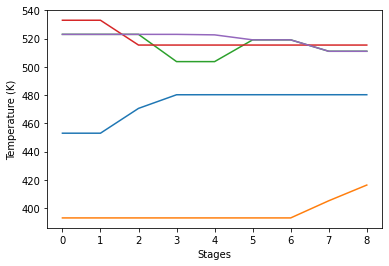

In [0]:
#df = df[:-1]
Imagem=len(df.iloc[:,0]) # Imagens+5 to get better graph postions
Change=range(Imagem)
for k in range(Trocas):
  plt.plot(Change,df.iloc[:,k])

plt.xlabel('Stages')
plt.ylabel('Temperature (K)')

In [0]:
print(df)

            0           1           2           3           4
0  453.000000  393.000000  523.000000  533.000000  523.000000
1  453.000000  393.000000  523.000000  533.000000  523.000000
2  470.573243  393.000000  523.000000  515.426757  523.000000
3  480.224133  393.000000  503.698220  515.426757  523.000000
4  480.248695  393.000000  503.698220  515.426757  522.648482
5  480.248695  393.000000  519.117405  515.426757  519.117405
6  480.248695  393.000000  519.117405  515.426757  519.117405
7  480.248695  405.143510  511.021731  515.426757  511.021731
8  480.248695  416.275498  511.021731  515.426757  511.021731


In [0]:
#print(Rec_Tcold)
#print(Rec_Thot)

In [0]:
print(Split)
print(WhenSplit)
print(tempInicial)


2
1
[453.0, 393.0, 523.0, 533.0]


In [0]:

fobj=FUN
mut=0.5
crossp=0.5
NPAR=600
its=2000
cols=18
x=np.zeros((NPAR,cols))
for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]

x,BEST,FOBEST,XY,BEST_XY=de_bounds_matriz.de(bounds, mut, crossp, 
                                             NPAR, its,fobj,x)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars


In [0]:
print(BEST)

[  2.5344169    2.88039608   2.94447089   2.340278     2.05284497
   0.3310661    0.78536825   0.95173885   1.           0.90084521
 -20.         -20.         -20.           0.         -20.
   0.           0.           2.96134283]


In [0]:
xbest=BEST
print('=====================')
Tout,erro,Rec_Temp =Temperatura(xbest)
df=pd.DataFrame(Rec_Temp)
print('*****',Tout)
print(erro)
print(df)

***** [[493. 428. 503. 473. 493.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Text(0, 0.5, 'Temperature (K)')

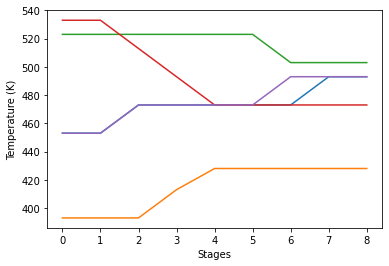

In [0]:
Imagem=len(df.iloc[:,0]) # Imagens+5 to get better graph postions
Change=range(Imagem)
for k in range(Trocas):
  plt.plot(Change,df.iloc[:,k])

plt.xlabel('Stages')
plt.ylabel('Temperature (K)')